In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, clear_output

from data import (
    load_dataset,
    dataset_info,
    summary_statistics,
    general_health_to_numeric,
    age_category_to_numeric,
    binary_columns_to_numeric,
    checkup_to_numeric,
    preprocess,
    plot_numeric_distributions,
    plot_normality_qq,
    plot_categorical_distributions,
)

from regression import (
    run_linear,
    run_xgboost,
    run_random_forest,
    run_ridge,
    run_gradient_boosting,
    compare_models,
    plot_correlation,
    spearman_correlation,
    mann_whitney_u_correlation,
    pearson_correlation,
    check_normality,
    make_everyone_exercise,
    evaluate_top_models_on_test_set
)

df = load_dataset("data/data.csv")

# Numerične spremenljivke
Numerične spremenljivke so:
- BMI: indeks med telesno težo in višino, višji BMI je ponavadi slabši za zdravje.
- Spremenljivke ki omenjajo sadje, alkohol, pražen krompir in zeleno zelenjavo nam povejo koliko konzumirajo na tedenski ravni.
- Height_(cm) in Weight_(kg) nam poveta koliko je teža in višina, uporabijo se za izračun BMI.

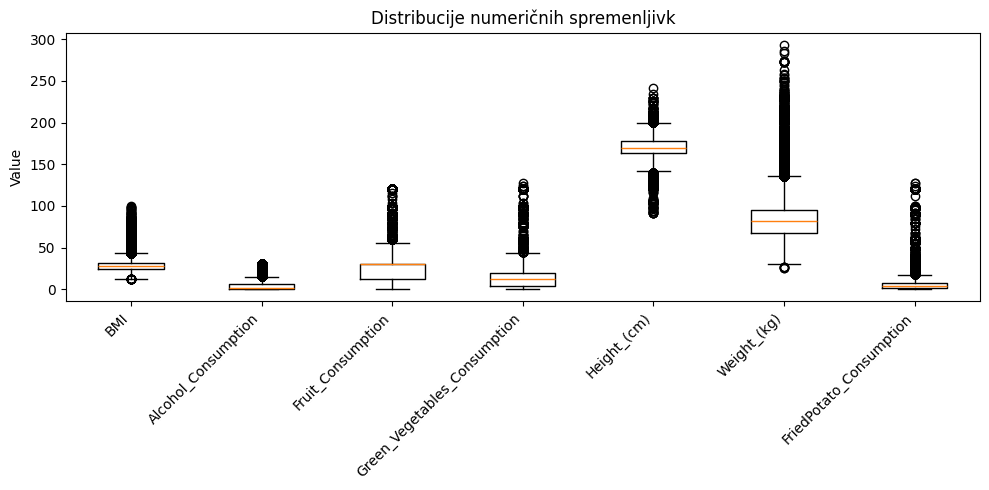

In [2]:
plot_numeric_distributions(df)

# Kategorične spremenljivke
- Heart_Disease nam pove če ima srčno bolezen.
- Smoking_History nam pove če ima zgodovino kajenja, vendar je to lahko zavajujoče saj nam ne pove kako dolgo nazaj je to bilo in če še vedno kadijo.
- Exercise: Če so v zadnjem času telovadili.
- Sex: spol
- Diabetes: če imajo diabetis
- Depression: če imajo simptome depresije
- Arthritis: če imajo artritis
- General_Health: to je ocena ki jo udeleženec sam poda o tem kako dobro je njegovo zdravje.
- Age_Category nam pove v katero kategorijo starosti spadajo udeleženci, iz grafa vidimo da so večinoma starejši.

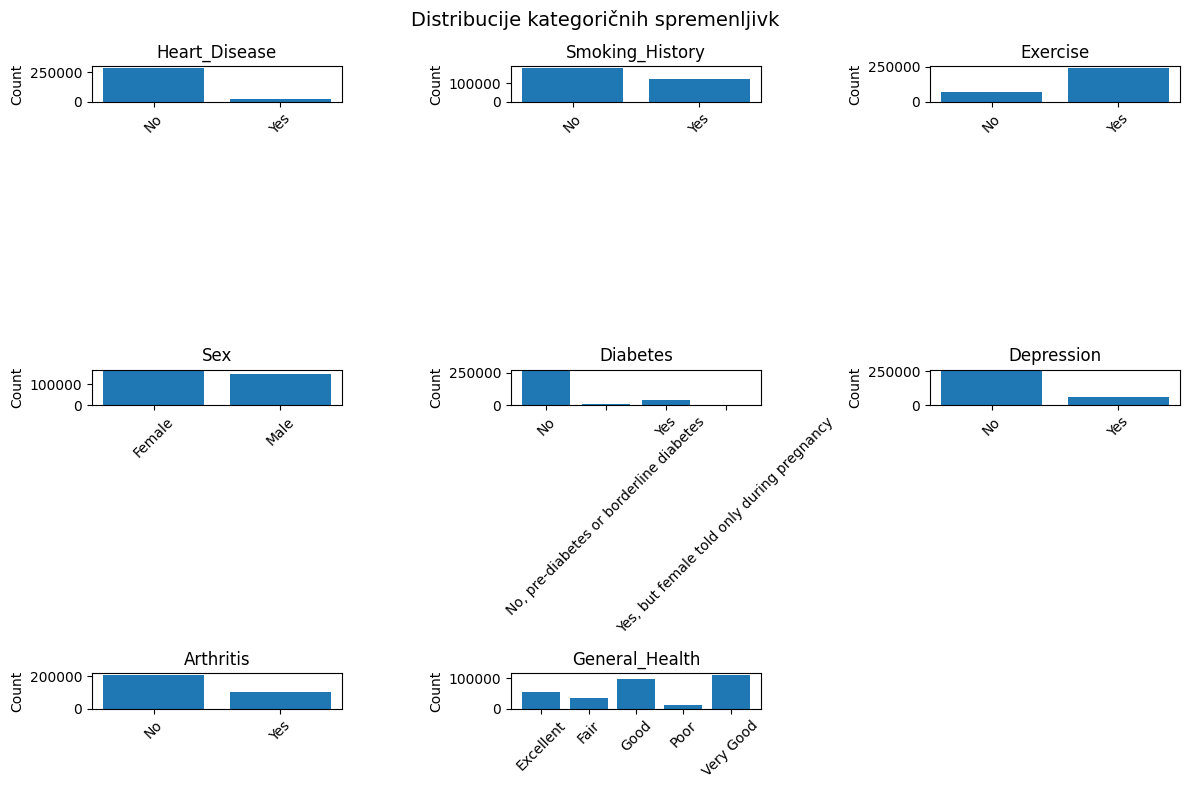

In [3]:
plot_categorical_distributions(df)

# Q-Q grafi normalnosti
Iz grafov se vidi da je veliko udeležencev reklo da pije ali zelo veliko alkohola ali pa zelo malo, podobno je bilo s sadjem, zelenjavo in krompirjem. Pri ostalih je graf kot pričakovan.

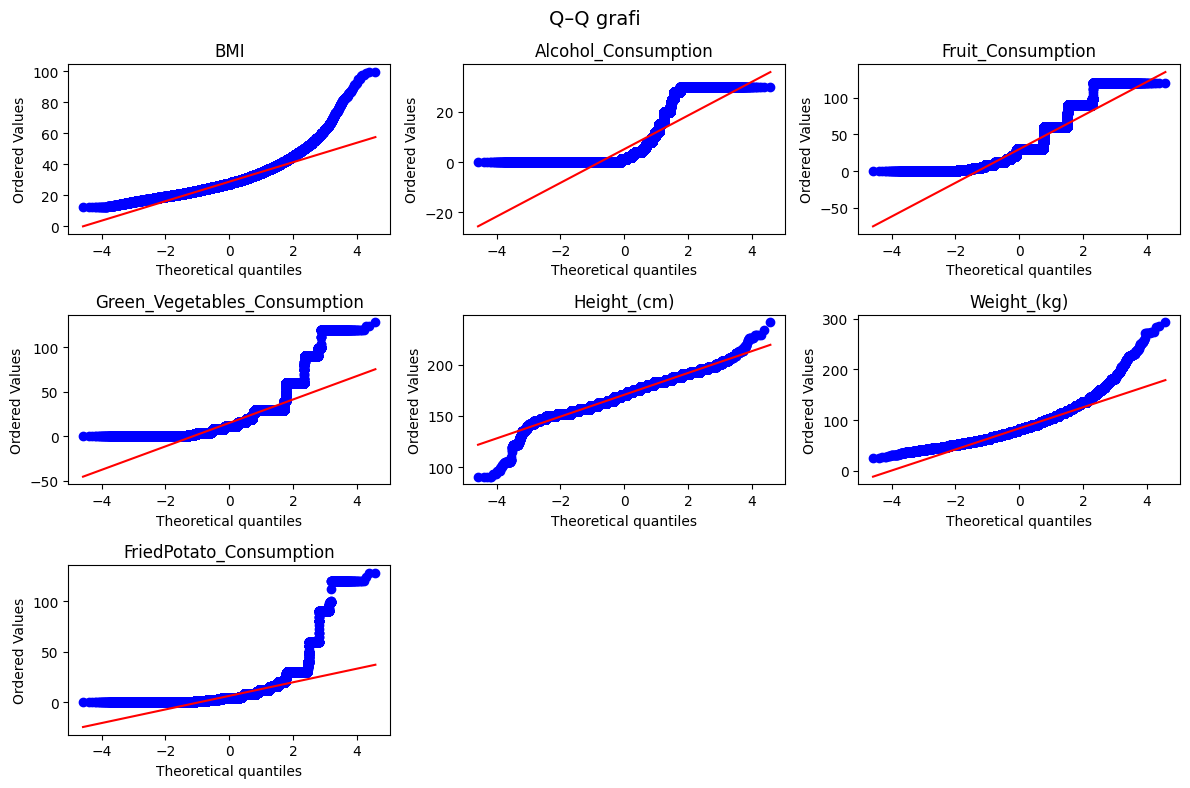

In [4]:
plot_normality_qq(df)

# Predprocesiranje podatkov
Tukaj smo odstranili vrstice brez podatkov in enkodirali kategorične spremenljivke v števila.

## Manjkajoči podatki

In [5]:
missing_by_col = df.isna().sum().sort_values(ascending=False)
missing_total = int(missing_by_col.sum())
missing_by_col, missing_total


(General_Health                  0
 Checkup                         0
 Exercise                        0
 Heart_Disease                   0
 Skin_Cancer                     0
 Other_Cancer                    0
 Depression                      0
 Diabetes                        0
 Arthritis                       0
 Sex                             0
 Age_Category                    0
 Height_(cm)                     0
 Weight_(kg)                     0
 BMI                             0
 Smoking_History                 0
 Alcohol_Consumption             0
 Fruit_Consumption               0
 Green_Vegetables_Consumption    0
 FriedPotato_Consumption         0
 dtype: int64,
 0)

## Duplikati

Enaki odgovori so mogoči pri različnih osebah, zato jih ne odstranjujemo. Posamezniki niso označeni z identifikacijo.

In [6]:
int(df.duplicated().sum())

80

## Predprocesiranje

Kategoričnim spremenljivkam najprej dodelimo številske vrednosti.

In [7]:
df = preprocess(df)

In [8]:
num_cols = df.select_dtypes(include="number").columns
minmax = df[num_cols].agg(["min","max"]).T
minmax

,min,max
General_Health,1.00,5.00
Checkup,0.00,1.00
Exercise,0.00,1.00
Heart_Disease,0.00,1.00
Skin_Cancer,0.00,1.00
Other_Cancer,0.00,1.00
Depression,0.00,1.00
Diabetes,0.00,1.00
Arthritis,0.00,1.00
Sex,0.00,1.00


Ekstremi so realni zato jih ne odstranjujemo. Najvišji človek v zgodovini je visok 272 cm, zato naš 241 cm ne izstopa. Zelo majhna višina ali teža sta lahko posledici zdravstvenih stanj, prav tako visoka teža/BMI.

# Regresija - BMI
V regresiji je odvisna spremenljivka BMI. Ker se teža in višina uporabljata za izračun BMI, te izpustimo.

## Korelacija med BMI in pomembnimi spremenljivkami

In [9]:
check_normality(df, ["BMI", "Alcohol_Consumption", "Fruit_Consumption", "Green_Vegetables_Consumption", "FriedPotato_Consumption", "General_Health", "Age_Category"])

,Variable,Shapiro_p,Normal,N_unique
6,Age_Category,1.975898e-38,NO,13
1,Alcohol_Consumption,4.850933e-72,NO,28
0,BMI,2.610495e-45,NO,1165
4,FriedPotato_Consumption,8.320162e-76,NO,32
2,Fruit_Consumption,1.689187e-55,NO,40
5,General_Health,1.747329e-49,NO,5
3,Green_Vegetables_Consumption,5.979346e-64,NO,37


In [10]:
mann_whitney_u_correlation(df, ["Heart_Disease", "Smoking_History", "Exercise", "Skin_Cancer", "Other_Cancer", "Depression", "Diabetes", "Arthritis", "Sex", "Checkup"])

,Feature,U_statistic,p_value,Median_BMI_0,Median_BMI_1
2,Exercise,9.936235e+09,0.000000e+00,29.26,27.12
7,Arthritis,8.698598e+09,0.000000e+00,27.05,28.74
6,Diabetes,3.375525e+09,0.000000e+00,27.12,30.85
5,Depression,6.656267e+09,0.000000e+00,27.34,28.75
9,Checkup,7.479164e+09,0.000000e+00,26.63,27.71
0,Heart_Disease,3.166298e+09,1.934898e-172,27.44,28.55
8,Sex,1.124022e+10,7.293510e-160,27.37,27.80
3,Skin_Cancer,4.438350e+09,2.534223e-68,27.46,27.06
1,Smoking_History,1.108117e+10,5.465959e-66,27.40,27.71
4,Other_Cancer,4.136852e+09,3.565470e-02,27.44,27.46


In [11]:
spearman_correlation(df, ["Alcohol_Consumption", "Fruit_Consumption", "Green_Vegetables_Consumption", "FriedPotato_Consumption"])

,Feature,Spearman_rho,p_value
0,Alcohol_Consumption,-0.095380,0.0
3,FriedPotato_Consumption,0.093054,0.0
1,Fruit_Consumption,-0.089118,0.0
2,Green_Vegetables_Consumption,-0.071518,0.0


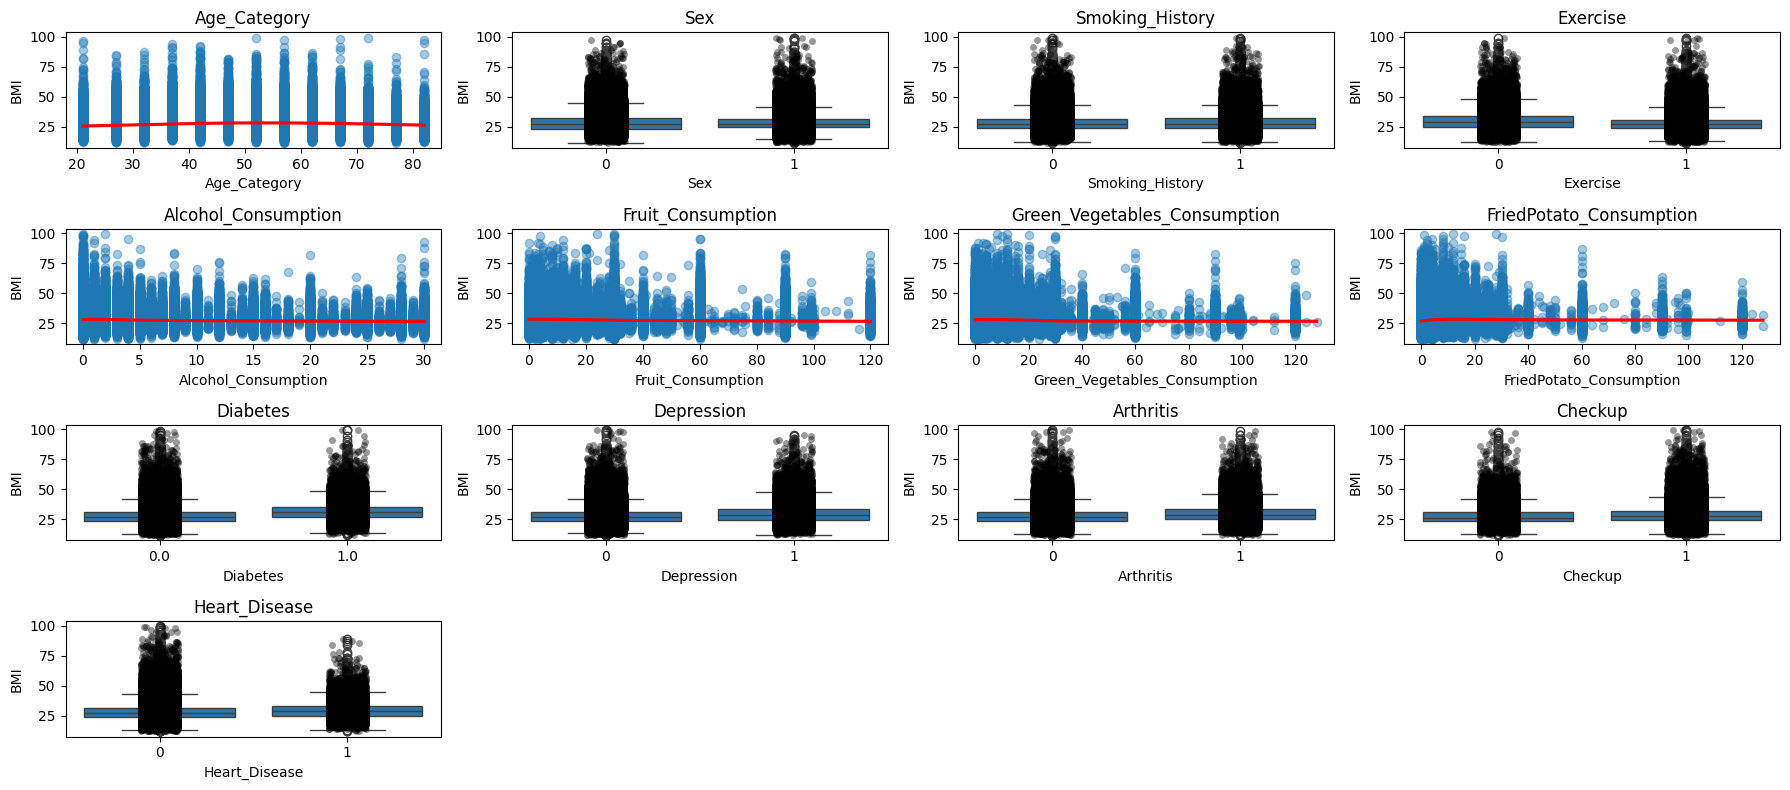

In [12]:
plot_correlation(df)

## Izbira pomembnih spremenljivk

### XGBoost

In [13]:
xgb_model, xgb_importance_df, xgb_rmse_mean, xgb_rmse_std, xgb_r2 = run_xgboost(df)
print(f"XGBoost RMSE: {xgb_rmse_mean:.3f}, R²: {xgb_r2:.3f}")
xgb_importance_df

XGBoost RMSE: 5.989, R²: 0.146


,Feature,Importance
0,Diabetes,0.429791
1,Arthritis,0.131538
2,Exercise,0.125921
3,Age_Category,0.077524
4,Depression,0.049086
5,Checkup,0.036275
6,Sex,0.034638
7,Alcohol_Consumption,0.030095
8,Smoking_History,0.028224
9,FriedPotato_Consumption,0.022985


### Random Forest

In [14]:
rf_model, rf_importance_df, rf_rmse_mean, rf_rmse_std, rf_r2 = run_random_forest(df)
print(f"Random Forest RMSE: {rf_rmse_mean:.3f}, R²: {rf_r2:.3f}")
rf_importance_df


Random Forest RMSE: 6.482, R²: 0.000


,Feature,Importance
0,Green_Vegetables_Consumption,0.190912
1,Fruit_Consumption,0.178818
2,FriedPotato_Consumption,0.150086
3,Age_Category,0.132556
4,Alcohol_Consumption,0.121017
5,Diabetes,0.047879
6,Smoking_History,0.035047
7,Sex,0.033683
8,Checkup,0.030701
9,Depression,0.023995


### Gradient Boosting

In [15]:
gb_model, gb_importance_df, gb_rmse_mean, gb_rmse_std, gb_r2 = run_gradient_boosting(df)
print(f"Gradient Boosting RMSE: {gb_rmse_mean:.3f}, R²: {gb_r2:.3f}")
gb_importance_df


Gradient Boosting RMSE: 6.023, R²: 0.135


,Feature,Importance
0,Diabetes,0.304401
1,Age_Category,0.272299
2,Exercise,0.111775
3,Arthritis,0.092889
4,Alcohol_Consumption,0.056967
5,FriedPotato_Consumption,0.048734
6,Depression,0.038727
7,Sex,0.027354
8,Fruit_Consumption,0.016184
9,Green_Vegetables_Consumption,0.013374


## Katere spremenljivke so pomembne?
RF ima slabše rezultate, saj je RMSE občutno višji. Pri RF nismo uspeli dosečti zelo dobrega rezultata saj je zelo časovno zahteven in potrebuje veliko virov da pridemo do dobrega rezultata. Zato smo upoštevali rezultate XGBoost in Gradient Boosting.

Pomembne spremenljivke so po XGBoost: **Diabetes**, **General_Health**, **Exercise**, **Arthritis**, **Age_Category**, **FriedPotato_Consumption**, **Depression**

In [16]:
important_features = ["Age_Category", "Sex", "Exercise", "Diabetes", "Arthritis", "General_Health", "FriedPotato_Consumption", "Depression"]

## Regresijski modeli

Uporabljeni modeli so Gradient Boosting, XGBoost, Linear Regression, Ridge Regression, Random Forest. Primerjamo RMSE in r2, pri modelih dreves AIC in BIC niso smiselni zato ta korak izpustimo.

In [17]:
df_comparison, models = compare_models(df, important_features)
df_comparison

,Model,RMSE (CV mean ± std),R²,Parameters
3,Gradient Boosting,5.953 ± 0.039,0.155221,"n_estimators=100, max_depth=5 [SAVED]"
4,XGBoost,5.990 ± 0.036,0.146536,"n_estimators=200, max_depth=6 [SAVED]"
2,Random Forest,6.042 ± 0.046,0.127633,"n_estimators=100, max_depth=5"
1,Ridge Regression,6.129 ± 0.042,0.105729,alpha=1.0 [SAVED]
0,Linear Regression,37.569 ± 0.512,0.105729,-


Najboljši modeli so Gradient Boosting, XGBoost, Linear Regression in Ridge Regression. Random Forest je dober vendar je veliko počasnejši, zato raje izberem Ridge Regression za testiranje.

In [18]:
models = {
    k: v for k, v in models.items()
    if k in ["ridge", "xgboost", "gradient_boosting"]
}
top_comparison = evaluate_top_models_on_test_set(df, models, important_features)
top_comparison

,Model,RMSE (test),MAE (test),R² (test)
1,gradient_boosting,5.996800,4.433272,0.155221
2,xgboost,6.027547,4.449835,0.146536
0,ridge,6.179650,4.597592,0.102919


## Vsi se gibamo
Zanima nas kaj se zgodi če se bi vsi gibali, saj lahko to večina ljudi z lahkoto implementira v svoje življenje.

In [19]:
metrics_table, six_sigma_table, p_value = make_everyone_exercise(df, models["xgboost"], important_features)
metrics_table


Predicted BMI decreased by 0.35.


,Metric,Before,After,Difference
0,MAE,4.403715,4.413428,0.009713
1,RMSE,5.927517,5.994893,0.067376
2,Mean BMI,28.657381,28.310133,-0.347248


In [20]:
if p_value < 0.05:
    print("Change: statistically significant")
else:
    print("Change: NOT statistically significant")
six_sigma_table

Change: statistically significant


,Metric,Before,After,Difference
0,Defects,214908.000000,214210.000000,-698.000000
1,DPMO,695823.916802,693563.949309,-2259.967493
2,Sigma Level,-0.512427,-0.505978,0.006449


Poleg tega da preverimo če več gibanja zniža BMI, smo želeli pogledati tudi če to rezultira v bolj natančni regresiji. Defekte merimo če se je predikcija zmotila za +-2 BMI. Na žalost to tu ni preveč smiselno. Več telovadbe zniža BMI ampak ni statistično signifikantno. To je problem zbirke podatkov saj ne merijo kvaliteto ali čas telovadbe, ampak samo če si v zadnjem času telovadil.

# Ugotovitve
Najbolj pomembne spremenljivke so diabetis, ocena splošnega zdravja, gibanje, artritis, starost. Malo manj pomembne so če imamo depresijo in če konzumiramo večje količine cvrtega krompirja.

- Diabetes: ljudje s prekomerno telesno težo so bolj nagnjeni k temu da razvijejo diabetes.
- Ocena splošnega zdravja: ljudje s slabšim splošnim zdravjem imajo lahko omejeno gibanje ali slabše diete, kar vpliva na telesno težo.
- Telovadba: redna telesna aktivnost neposredno vpliva na porabo kalorij kar pomeni manjšo telesno težo.
- Artritis: artritis lahko omeji telesno aktivnost, kar lahko vodi do povečanja teže.
- Starost: starejši ljudje imajo manj energije za aktivnost ali pa imajo druge bolezni ki vodijo do povečanja teže
- Depresija: lahko povzroči spremembe apetita in aktivnosti, kar posredno vpliva na telesno težo.
- Konzumacija cvrtga krompirja: če jejo več visokokaloričnega krompirja, je možnost da jejo več na splošno

## Pozitivni in negativni vplivi na BMI
Več gibanja ima pozitivni vpliv na BMI, torej ga zmanjša, prav tako ima pozitivni vpliv dobra ocena splošnega zdravja. Za binarne spremenljivke velja da če so resnične, višajo BMI. Višja starost viša BMI. Pogosta konzumacija cvrtega krompirja viša BMI.

## Zakaj je težko napovedati BMI?
Podatkovna zbirka ni bila narejena za napoved BMI. Pri konzumpciji hrane ni navedeno koliko jo pojejo, prav tako pri gibanju ni navedeno koliko se gibajo oz. kako kvalitetno je to gibanje za kurjenje maščobe. Ocena splošnega zdravja je lahko problematična saj je popolnoma subjektivna s strani pacienta, prav tako depresija. Problem pri binarnih spremenljivkah je da jih je večina zelo nagnjena k eni vrednosti.